In [2]:
import seaborn as sns, pandas as pd, warnings, xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [12]:
sns.set(style = 'whitegrid')
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large', titleweight = 'bold', titlesize = 18, titlepad = 10)
plt.rc('animation', html = 'html5')

In [7]:
def classify_health_impact(score):
    if score >= 80:
        return 0  
    elif score >= 60:
        return 1  
    elif score >= 40:
        return 2  
    elif score >= 20:
        return 3  
    else:
        return 4  

In [8]:
air = pd.read_csv('air_quality_health_impact_data.csv')
air_cleaned = air.drop(columns = ['RecordID'])
for col in ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3']:
    Q1 = air_cleaned[col].quantile(0.25)
    Q3 = air_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    air_cleaned[col] = air_cleaned[col].apply(lambda x: min(max(x, lower_bound), upper_bound))
air_cleaned['HealthImpactClass'] = air_cleaned['HealthImpactScore'].apply(classify_health_impact)

In [9]:
y = air_cleaned['HealthImpactClass']
x = air_cleaned.drop(['HealthImpactClass', 'HealthImpactScore'], axis = 1)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 52)

In [11]:
xgbModel = xgb.XGBClassifier(objective = 'multi:softmax', num_class = 5, eval_metric = 'mlogloss', use_label_encoder = False)
xgbModel.fit(xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

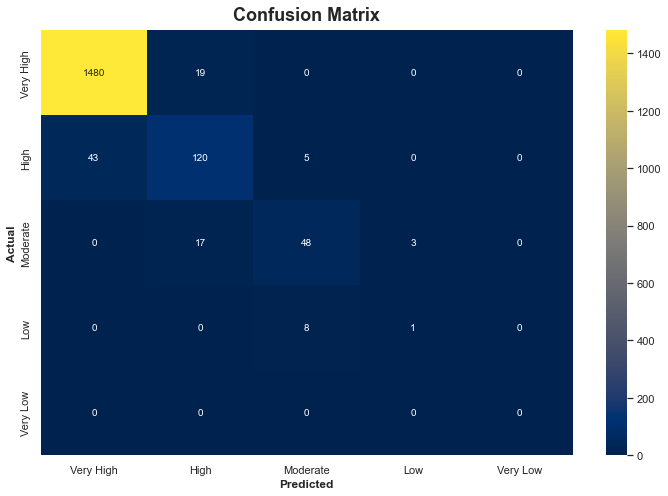

In [17]:
ypred = xgbModel.predict(xtest)
plt.figure(figsize = (10, 7))
class_labels = ['Very High', 'High', 'Moderate', 'Low', 'Very Low']
sns.heatmap(confusion_matrix(ytest, ypred, labels = [0, 1, 2, 3, 4]), annot = True, cmap = 'cividis', fmt = 'd', xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print(f"Accuracy: {accuracy_score(ytest, ypred):.2f}")
print("\n")
print(classification_report(ytest, ypred))

Accuracy: 0.95


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1499
           1       0.77      0.71      0.74       168
           2       0.79      0.71      0.74        68
           3       0.25      0.11      0.15         9

    accuracy                           0.95      1744
   macro avg       0.69      0.63      0.65      1744
weighted avg       0.94      0.95      0.94      1744

